# pyMassEvac tutorial - simulating with policy function approximations

This tutorial demonstrates how to use the `pyMassEvac` python package to study a multi-domain response to a mass evacuation. It does so by using the environment provided by the package to simulate the result of using policies that are best described as Policy Function Approximations.

Throughout this tutorial, reference will be made to an article - Rempel (2024). The citation for this article is as follows:

Rempel, M., Modelling a major maritime disaster scenario using the universal modelling framework for sequential decisions, Safety Science, Volume 171, 2024, 106379, ISSN 0925-7535, https://doi.org/10.1016/j.ssci.2023.106379.

In [1]:
# import packages
import gymnasium as gym
import numpy as np
import pandas as pd
import copy
import math
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

from IPython.display import clear_output
import time

Next, import two modules from the pyMassEvac package. The first module, mass_evacuation, contains the mass evacuation gymnasium environment. The second module, mass_evacuation_policy, contians a set of benchmark policy function approximations as described in Rempel (2024).

In [2]:
from pyMassEvac.mass_evacuation import MassEvacuation
from pyMassEvac.mass_evacuation_policy import MassEvacuationPolicy

## Setting up the initial state, environment, and decision policies

First, we define the seed used in the random number generator. This seed, which is the same as used in Rempel (2024) (although not explicitly reported), is used to initiate a random number generator. This single generator is used to: 

- generate the initial transition times of individuals between medical conditions;
- generate new transition times when an individual is loaded on or off the ship; and
- generate random numbers to determine if an individual has transitioned between medical conditions each time the transition function is executed.

Note: The pyMassEvac package uses a separate random number generator for the benchmark policies, but a seed is not provided in this instance as the benchmark policies used do not require the generator.

Second, we define the initial state $S_0$. This is the same initial state used in Rempel (2024), a combination of the parameter listed in Table 5 and the initial values of the state variable listed in equation (1). However, note the addition of the initial helicopter arrival time and initial ship arrival time. In Rempel (2024) these were considered as separate parameters that were input to the simulation; they are now integrated into the initial state in order to provide a clearner interface.

In [3]:
# set the environment's seed and initial state that was used in Rempel (2024)
rempel_2024_seed = 20180529

# Set the initial state
rempel_2024_initial_state = {
            'm_e' : {'white' : 120, 'green' : 48, 'yellow' : 8, 'red' : 1.5},
            'm_s' : {'green' : 48, 'yellow' : 72, 'red' : 120},
            'c_h' : 10,
            'c_s' : 50,
            'delta_h' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'delta_s' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'eta_h' : 3,
            'eta_sl' : 24,
            'eta_su' : 1,
            'tau_k' : 0,
            'e_k' : 0,
            'rho_e_k' : {'white' : 0, 'green' : 475, 'yellow' : 20, 'red' : 5},
            'rho_s_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
            'initial_helo_arrival' : [48],
            'initial_ship_arrival' : [0]
        }

Next, we create the gymnasium environment and a policy object. The gymnasium environment requries three parameters: 

- the initial state $S_0$;
- the seed for the random number generator; and
- whether or not the np.random.default_rng generator is to be used (default_rng = True) or not (default_rng = False).

In the case of False, the random number generator is created using np.random.RandomState (which was used in Rempel (2024)). Given that np.random.default_rng is a replacement for RandomState, it is advised to set default_rng = True. In the case below, we set it to False to generate results that are in good agreement with Rempel (2024). 

In [4]:
# create the environment and policy objects
env = MassEvacuation(initial_state = rempel_2024_initial_state, \
                     seed = rempel_2024_seed,
                     default_rng = False)

policy = MassEvacuationPolicy()

## Setting up the simulation

With the environment and policy objects created, we are now in a position to define a function to execute the simulation. The aim of this simulation is to generate results similar to those presented in Figure 3 in Rempel (2024); that is, given one helicopter that is responding to the incident, how does the number of lives saved depend on the arrival time of the ship. Given this aim, this function `simulate_scenario` takes five parameters:

- `env`: the environment object that represents the transition function and generates the exoengous information;
- `policy`: the policy object that contains the policies that will be used to load a helicopter, load the ship, and unload the ship;
- `ship_arrival_time': a numpy array that lists the hours that the ship arrives after the individuals arrive at the evacuation site;
- `single_scenario`: a boolean that determines if when the environment is reset whether it defaults to the original state as defined by $S_0$ (`single_scenario = True`), or whether new initial transition times between medical conditions for the individauls are randomly generated (`single_scenario = False`). The default value is set to True; and
- `num_trials`: the number of trials that are executed for each ship arrival time. The defualt value is set to 30.

The function returns a Pandas data frame that contains three columns: the ship arrival time, the trial number, and the number of lives saved. 

In [5]:
def simulate_scenario(env, policy, ship_arrival_time, single_scenario = True, num_trials = 30):

    # define the default action
    action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
              'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
              'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
             }
    
    # Create a pandas data frame to store the results
    results = pd.DataFrame(columns = ['Ship arrival time', 'Trial', 'Objective'])
    
    for idx, ship_arrival in enumerate(ship_arrival_time):
    
        env.initial_state['initial_ship_arrival'] = [ship_arrival] 
        
        for t in tqdm(range(num_trials)):

            options = {}
            options['single_scenario'] = single_scenario
            env.reset(options = options)       
            
            objective = 0
            done = False
        
            while not done:
        
                # The action space in this is defined by three types of actions that can be taken that depend on the event that is occuring.
                # The actions are:
                # - load the helicopter with {white, green, yellow, red}
                # - load the ship with {whtie, green, yellow, red}
                # - unload the ship with {white, green, yellow, red}
        
                action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                          'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                          'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
                          }
        
                if (env.state['e_k']) == 1:
        
                    # load the helicopter
                    params = {}
                    params['total_capacity'] = env.initial_state['c_h']
                    params['individual_capacity'] = env.initial_state['delta_h']
                    action['x_hl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                         params = params)
                elif (env.state['e_k'] == 2):
        
                    # load the ship
                    params = {}
                    params['total_capacity'] = env.initial_state['c_s']
                    params['individual_capacity'] = env.initial_state['delta_s']
                    action['x_sl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                         params = params)
                elif (env.state['e_k'] == 3):
        
                    # unload the ship
                    action['x_su_k'] = policy.white_unloading_policy(state = env.state) 

                # Convert action from a dict to ndarray
                action = env.action_dict_to_ndarray(action)
                
                observation, reward, terminated, truncated, info = env.step(action)

                observation = env.observation_ndarray_to_dict(observation)
                env.state = observation
        
                objective += reward
                done = terminated or truncated
    
            trial_result = pd.DataFrame([{'Ship arrival time': ship_arrival, 'Trial': t, 'Objective': objective}])
            results = pd.concat([results, trial_result], ignore_index = True)

    return results

Now that `simulate_scenario` is defined, we can use it to simulate the mass evacuation scenario. In the following cell, we do this for a range of ship arrival times - ranging from zero to 168 hours after the individuals arrive at the evacuation site. For each ship arrival time, we run 30 trials and generate results when the `single_sceanrio` is set to `True`, and when it is set to `False`.

In [6]:
# Simulate the mass evacuation scenario
num_trials = 30
ship_arrival_time = np.arange(0, 180, 12)

results_single = simulate_scenario(env, policy, ship_arrival_time = ship_arrival_time, \
                                   single_scenario = True, num_trials = num_trials)

results_multiple = simulate_scenario(env, policy, ship_arrival_time = ship_arrival_time, \
                                     single_scenario = False, num_trials = num_trials)

100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.58it/s]


With the results generated in the above cell, we are now in a position to create a plot similiar to Figure 3 in Rempel (2024). The following cell plots the results generated above when `single_scenario = True` (left panel) and depicts the results as a boxplot for each ship arrival hour. The results from the same scenario, i.e., one helicopter, variable ship arrival, are depicted as red circles which represent the expected number of lives saved as listed in Table 6 in Rempel (2024). Inspecting the figure reveals good agreement between the results presented in Rempel (2024) and the `pyMassEvac` package.

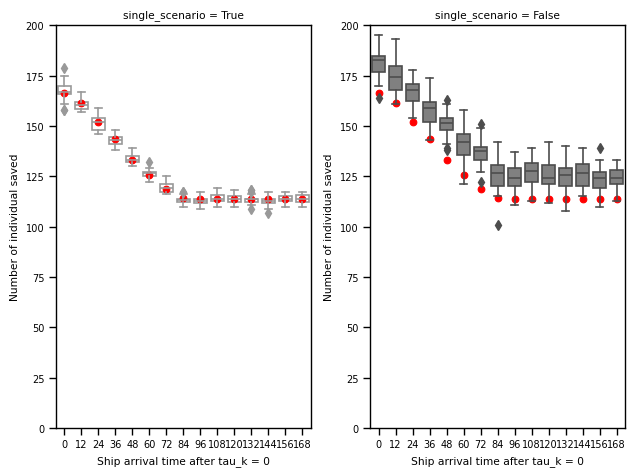

In [7]:
# Create a figure simiilar to Figure 3 in Rempel (2024)

sns.set_context('paper', font_scale = 0.8)

plt.subplot(1,2,1)
ax = sns.boxplot(data = results_single, x = 'Ship arrival time', y = 'Objective', color = "white")
ax.set(ylabel = 'Number of individual saved', xlabel = 'Ship arrival time after tau_k = 0')
ax.set_ylim(bottom = 0, top = 200)
ax.set_title('single_scenario = True')

# Define the mean number of individuals saved as listed in Table 6, column one helo in Rempel (2024).
previous_results = np.array([166.20, 161.37, 152.17, 143.73, 133.30, 125.67, 118.60, 114.43, 113.53, 113.53,
                             113.53, 113.53, 113.53, 113.53, 113.53])

for idx, t in enumerate(ship_arrival_time):
    plt.scatter(idx, previous_results[idx], color = 'red')

plt.subplot(1,2,2)
ax = sns.boxplot(data = results_multiple, x = 'Ship arrival time', y = 'Objective', color = "gray")
ax.set(ylabel = 'Number of individual saved', xlabel = 'Ship arrival time after tau_k = 0')
ax.set_ylim(bottom = 0, top = 200)
ax.set_title('single_scenario = False')

for idx, t in enumerate(ship_arrival_time):
    plt.scatter(idx, previous_results[idx], color = 'red')

plt.tight_layout()

As a comparison, the figure in the right panel depicts the results obtained when `single_scenario = False`. In this case, the expected number of individuals saved, differs those values reported in Rempel (2024) which are depicted as red circles. The reason for this difference is that the left panel simulates a single initial state with respect to the individuals' transition times between medical conditions, allowing the comparison between decision policies to focus on the effects of the policies themselves. It should also be noted that the uncertainty in the number of lives saved is larger in the right panel as compared to the left; again, this is directly due to fact that multiple initial states are used.

Next, what happens if the ship doesn't show up? To model this scenario, we can set the ship arrival time to a value that is longer than time for all individuals to be transported from the evacuation site via helicopter. Inspection of Figure 6(b) in Rempel (2024) reveals that when using one helicopter, all individuals are removed by hour 400 when the ship arrives at $\tau_k = 0$. Thus, we will set the ship arrival time to 400.

In [8]:
options = {}
options['single_scenario'] = False
env.reset(options = options)
ship_arrival_time = np.array([400])
results = simulate_scenario(env, policy, ship_arrival_time = ship_arrival_time, \
                                   single_scenario = True, num_trials = num_trials)

100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.71it/s]


The expected number of lives saved if the ship does not arrived is:

In [9]:
results.Objective.mean()

113.3